# Let's start!

We are going to start understanding the data we have, cleaning the dataframes as needed and obtaining new features from the data.



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## portfolio

In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

### Transforming categorical variables into columns

In [7]:
# Convert offer_type (categorical variable) into columns
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio.offer_type)], axis=1)
# Drop offer_type columns
portfolio = portfolio.drop(columns=['offer_type'])

portfolio.head()

,reward,channels,difficulty,duration,id,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
1,10,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
2,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,0,0,1
3,5,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
4,5,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [8]:
# Convert channels (categorical variable) into columns
channels_set = set()

# Getting possible channels
for channels in portfolio.channels:
    channels_set |= set(channels)
print("Possible channels:", channels)

# Filling with 0's the channel columns
for channel in channels_set:
    portfolio[channel] = 0

# Setting 1's on the channels contained in each row
for index, channels in enumerate(portfolio.channels):
    for channel in channels:
        portfolio.at[index, channel] = 1
        
# Dropping channels column
portfolio = portfolio.drop(columns=['channels'])

portfolio.head()

Possible channels: ['web', 'email', 'mobile']


,reward,difficulty,duration,id,bogo,discount,informational,web,email,social,mobile
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,0,1,1,1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0


In [9]:
# Lets save the new portfolio dataset
portfolio.to_json('clean_data/portfolio.json')

## profile

In [10]:
profile.shape

(17000, 5)

In [11]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

### Understanding and cleaning age column

In [14]:
# Checking the age distribution
profile.age.hist()

The oldest person alive is 116 years old... so.. something is wrong.. let's check it out

In [15]:
profile[profile.age > 100].groupby('age').id.count()

age
101       5
118    2175
Name: id, dtype: int64

Probably something went wrong with the database and set many users age to 118, so we have to do something to clear this mess up.
We have some possible things to do here:

1. Put the value as None instead of 118
2. Try to Infer their age
3. Use the most frequent age instead

For now let's just put None instad..

In [16]:
profile.loc[profile.age > 100, 'age'] = None

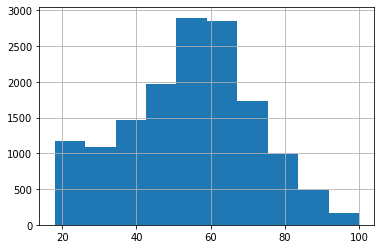

In [17]:
profile.age.hist()

In [18]:
# Let's check how populated is age field
len(profile[~profile.age.isnull()])/profile.shape[0]

0.8717647058823529

### Understanding gender column

gender
F    6129
M    8484
O     212
Name: id, dtype: int64


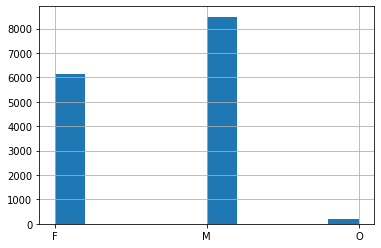

In [19]:
# Checking the gender distribution
print(profile.groupby('gender').id.count())
profile.gender.hist()

In [20]:
# Let's check how populated is gender field
len(profile[~profile.gender.isnull()])/profile.shape[0]

0.8720588235294118

In [21]:
# Let's get dummies from categorical column gender
profile = pd.concat([profile, pd.get_dummies(profile.gender)], axis=1).drop(columns='gender')

### Understanding income column

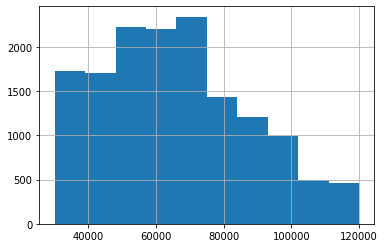

In [22]:
# Checking the gender distribution
profile.income.hist()

In [23]:
# Let's check how populated is income field
len(profile[~profile.income.isnull()])/profile.shape[0]

0.8720588235294118

### Understanding and cleaning became_member_on column

In [24]:
# Let's check how populated is became_member_on field
profile[profile.became_member_on.isnull()]

,age,id,became_member_on,income,F,M,O


Yeeeeii!! It's completely filled

In [25]:
# Converting became_member_on integer into date
profile['sign_up_date'] = [datetime.strptime(str(became_member_on), '%Y%m%d') for became_member_on in profile.became_member_on]

In [26]:
# Getting year from sign up date
profile['sign_up_year'] = [date.year for date in profile['sign_up_date']]

In [27]:
# Getting month from sign up date
profile['sign_up_month'] = [date.month for date in profile['sign_up_date']]

In [28]:
# Getting day from sign up date
profile['sign_up_day'] = [date.day for date in profile['sign_up_date']]

In [29]:
# Getting weekday from sign up date
profile['sign_up_weekday'] = [date.weekday() for date in profile['sign_up_date']]

In [30]:
# Setting 1 if the sign up date was on weekend or 0 if not
profile['sign_up_weekend'] = [date.weekday()//5 for date in profile['sign_up_date']]

There are another cool things that we could infer from date like hollydays but.. we can start with these ones.
Let's check the distributions

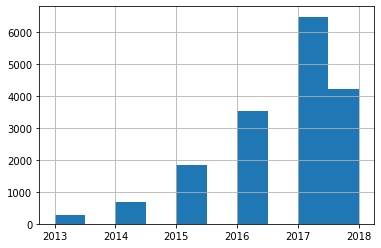

In [31]:
profile.sign_up_year.hist()

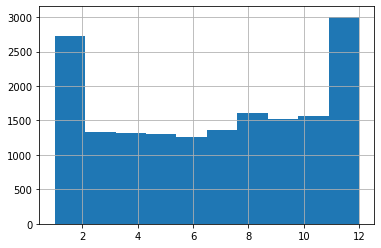

In [32]:
profile.sign_up_month.hist()

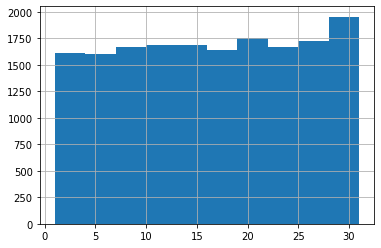

In [33]:
profile.sign_up_day.hist()

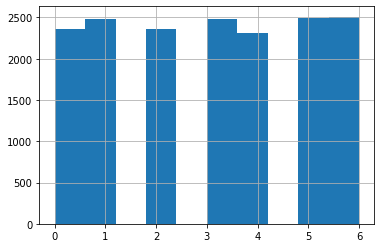

In [34]:
profile.sign_up_weekday.hist()

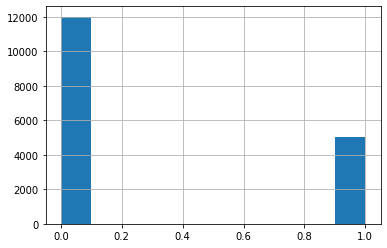

In [35]:
profile.sign_up_weekend.hist()

In [36]:
# Lets save the new profile dataset
profile.to_json('clean_data/profile.json')

## transcript

In [37]:
transcript.shape

(306534, 4)

In [38]:
transcript.sample(10)

,person,event,value,time
242582,62fc04236fbd4ea9a8402f0cca70942d,transaction,{'amount': 18.74},564
32958,1845024a271d49b586a9041c19602472,transaction,{'amount': 0.78},60
132613,111b775a2e034c70b33a94936c2a0a73,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,348
30863,7cf26de9d6324edab6b15e19bda2bec7,transaction,{'amount': 5.21},48
44094,90978e0ee5ae4ce5a08a3e76e3b6e6ba,transaction,{'amount': 25.16},108
278194,6ae4f7f014eb47e9a059839788cd8de3,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,612
216691,a305233f5c944df5bcaacc029658e085,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},504
86734,1948b3c194c542d0a2a084a558f31834,transaction,{'amount': 9.8},216
18675,a5360772ba38441692f0d7cbc1d643b6,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,12
223563,90ed420d955b43d39508069c1407c4eb,transaction,{'amount': 6.07},516


In [39]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [40]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [41]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [42]:
events = transcript.event.unique()
for event in events:
    print(event)
    print(transcript[transcript.event==event].head().value, '\n')

offer received
0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object 

offer viewed
12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object 

transaction
12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object 

offer completed
12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c

In this dataset are 4 different types of events mixed up, so I think a clearer way to work with these data is splitting up the dataset in 4 different datasets

In [43]:
# Splitting the data into subdataframes
event_dataframes = {}
for event, event_df in transcript.groupby('event'):
    event_dataframes[event] = event_df

For every event we are going to obtain features from the value column and also we are going to obtain the number of days
from time column

In [44]:
# offer received

# Obtaining columns from value
event_dataframes['offer received']['offer_id'] = [value.get('offer id') for value in event_dataframes['offer received'].value]

# Droping value column
event_dataframes['offer received'].drop(columns='value', inplace=True)

print("offer received rows:", event_dataframes['offer received'].shape[0])

# Saving dataframe as json
event_dataframes['offer received'].to_json('clean_data/offers_received.json')

event_dataframes['offer received'].sample(5)

offer received rows: 76277


,person,event,time,offer_id
117721,f15b7751efdf45fe9c4a4e08fc474744,offer received,336,4d5c57ea9a6940dd891ad53e9dbe8da0
117340,b8bb067cf8074d1597e9b842cce65161,offer received,336,ae264e3637204a6fb9bb56bc8210ddfd
162649,149712de2ae24c219b992cb3a5f432bc,offer received,408,0b1e1539f2cc45b7b9fa7c272da2e1d7
208884,3ae3b5f2473b40cc807427b31cc8ad4b,offer received,504,fafdcd668e3743c1bb461111dcafc2a4
256382,04fcbc5e1faf4b7bba20116ecb30ca17,offer received,576,f19421c1d4aa40978ebb69ca19b0e20d


In [45]:
# offer viewed

# Obtaining columns from value
event_dataframes['offer viewed']['offer_id'] = [value.get('offer id') for value in event_dataframes['offer viewed'].value]

# Droping value column
event_dataframes['offer viewed'].drop(columns='value', inplace=True)

print("offer viewed rows:", event_dataframes['offer received'].shape[0])

# Saving dataframe as json
event_dataframes['offer viewed'].to_json('clean_data/offers_viewed.json')

event_dataframes['offer viewed'].sample(5)

offer viewed rows: 76277


,person,event,time,offer_id
18810,c277f3283f5a445e9eef688cf5f69289,offer viewed,12,2298d6c36e964ae4a3e7e9706d1fb8c2
179261,15c0c8d1534340888a61a94f4fe05a44,offer viewed,432,2906b810c7d4411798c6938adc9daaa5
184058,343e4bfac5aa46ad92d6d02b874a879d,offer viewed,444,fafdcd668e3743c1bb461111dcafc2a4
136886,083d316ee57640689731e5e7be9d5c20,offer viewed,360,ae264e3637204a6fb9bb56bc8210ddfd
226251,8490563e978e4707b584e35ad1d56125,offer viewed,522,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [46]:
# transaction

# Obtaining columns from value
event_dataframes['transaction']['amount'] = [value.get('amount') for value in event_dataframes['transaction'].value]

# Droping value column
event_dataframes['transaction'].drop(columns='value', inplace=True)

print("transaction rows: ", event_dataframes['transaction'].shape[0])

# Saving dataframe as json
event_dataframes['transaction'].to_json('clean_data/transactions.json')

event_dataframes['transaction'].sample(5)

transaction rows:  138953


,person,event,time,amount
29689,722861f1006e4bd19439516cce98fbfd,transaction,48,15.97
238470,e5f9566e11e740f5b61d9ca8802e13b8,transaction,552,4.43
281733,abc4359eb34e4e2ca2349da2ddf771b6,transaction,618,0.96
177145,af8874dd6a6548d6ba4e9a53a70825ad,transaction,426,27.83
191965,4399fd7521de4731838ac1215975a5d8,transaction,468,4.13


In [47]:
 # transaction

# Obtaining columns from value
event_dataframes['offer completed']['offer_id'] = [value.get('offer_id') for value in event_dataframes['offer completed'].value]
event_dataframes['offer completed']['reward'] = [value.get('reward') for value in event_dataframes['offer completed'].value]

# Droping value column
event_dataframes['offer completed'].drop(columns='value', inplace=True)

print("offer completed rows: ", event_dataframes['offer completed'].shape[0])

# Saving dataframe as json
event_dataframes['offer completed'].to_json('clean_data/offers_completed.json')

event_dataframes['offer completed'].sample(5)

offer completed rows:  33579


,person,event,time,offer_id,reward
176314,7915f1af7f464835b7967dbb625112f0,offer completed,426,f19421c1d4aa40978ebb69ca19b0e20d,5
296721,9a9a6f44405f49fdb0c3fa45109767d5,offer completed,672,2906b810c7d4411798c6938adc9daaa5,2
224592,2fbbdca82a9c45d6898d5a18d0227410,offer completed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,5
286006,99c3a74676344e3b8689d34aa78e9113,offer completed,636,2298d6c36e964ae4a3e7e9706d1fb8c2,3
232351,916bae5b5bdf49ad80b2edfbdd763e14,offer completed,534,4d5c57ea9a6940dd891ad53e9dbe8da0,10
